# TFIDF

In [1]:
import pickle
import numpy as np
import string
import os

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords

import seaborn as sns

from tqdm.notebook import tqdm

import pandas as pd

from joblib import dump, load

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from yellowbrick.model_selection import learning_curve

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /Users/ras/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ras/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ras/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Preprocessing

In [2]:
# Gloabal variables
pos_data_path = "path/to/train_pos.txt"
neg_data_path = "path/to/train_neg.txt"
test_data_path = "path/to/test.txt"
save_preds = "path/to/predictions.txt"

model_path = "path/to/model.joblib"

seed = 42

### Reading files

In [3]:
with open(pos_data_path) as f:
    pos = f.readlines()

with open(neg_data_path) as f:
    neg = f.readlines()

with open(test_data_path) as f:
    test = f.readlines()

print("Pos has size: {}".format(len(pos)))
print("Neg has size: {}".format(len(neg)))
print("Test has size: {}".format(len(test)))

Pos has size: 1250000
Neg has size: 1250000
Test has size: 10000


In [4]:
print(pos[0])

<user> i dunno justin read my mention or not . only justin and god knows about that , but i hope you will follow me believe 15



In [5]:
# Lowercasing sentence
pos = list(map(lambda x: x.lower(), tqdm(pos)))
neg = list(map(lambda x: x.lower(), tqdm(neg)))
test = list(map(lambda x: x.lower(), tqdm(test)))

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
print(pos[0])

<user> i dunno justin read my mention or not . only justin and god knows about that , but i hope you will follow me believe 15



In [7]:
# Tokenizing sentence
tokenizer = RegexpTokenizer(r'\w+')

pos = list(map(lambda x: tokenizer.tokenize(x), tqdm(pos)))
neg = list(map(lambda x: tokenizer.tokenize(x), tqdm(neg)))
test = list(map(lambda x: tokenizer.tokenize(x), tqdm(test)))

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
print(pos[0])

['user', 'i', 'dunno', 'justin', 'read', 'my', 'mention', 'or', 'not', 'only', 'justin', 'and', 'god', 'knows', 'about', 'that', 'but', 'i', 'hope', 'you', 'will', 'follow', 'me', 'believe', '15']


In [9]:
# Removing numbers
pos = list(map(lambda x: [i for i in x if not i.isnumeric()], tqdm(pos)))
neg = list(map(lambda x: [i for i in x if not i.isnumeric()], tqdm(neg)))
test = list(map(lambda x: [i for i in x if not i.isnumeric()], tqdm(test)))

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
# Removing stopwords
stopwords_set = stopwords.words('english')

pos = list(map(lambda x: [w for w in x if not w in stopwords_set], tqdm(pos)))
neg = list(map(lambda x: [w for w in x if not w in stopwords_set], tqdm(neg)))
test = list(map(lambda x: [w for w in x if not w in stopwords_set], tqdm(test)))

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
print(pos[0])

['user', 'dunno', 'justin', 'read', 'mention', 'justin', 'god', 'knows', 'hope', 'follow', 'believe']


In [12]:
# Stemming
stemmer = PorterStemmer()

pos = list(map(lambda x: [stemmer.stem(w) for w in x], tqdm(pos)))
neg = list(map(lambda x: [stemmer.stem(w) for w in x], tqdm(neg)))
test = list(map(lambda x: [stemmer.stem(w) for w in x], tqdm(test)))

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
print(pos[0])

['user', 'dunno', 'justin', 'read', 'mention', 'justin', 'god', 'know', 'hope', 'follow', 'believ']


In [14]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()

pos = list(map(lambda x: [lemmatizer.lemmatize(w) for w in x], tqdm(pos)))
neg = list(map(lambda x: [lemmatizer.lemmatize(w) for w in x], tqdm(neg)))
test = list(map(lambda x: [lemmatizer.lemmatize(w) for w in x], tqdm(test)))

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/1250000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [15]:
print(pos[0])

['user', 'dunno', 'justin', 'read', 'mention', 'justin', 'god', 'know', 'hope', 'follow', 'believ']


In [16]:
pos_df = pd.DataFrame(columns=['Label', 'Words'])
pos_df['Words'] = pos
pos_df['Label'] = 'pos'

neg_df = pd.DataFrame(columns=['Label', 'Words'])
neg_df['Words'] = neg
neg_df['Label'] = 'neg'

test_df = pd.DataFrame(columns=['Words'])
test_df['Words'] = test

train_df = pd.concat([pos_df, neg_df])

In [17]:
train_df.head(5)

,Label,Words
0,pos,"[user, dunno, justin, read, mention, justin, g..."
1,pos,"[logic, dumb, even, crop, name, photo, tsk, url]"
2,pos,"[user, put, casper, box, loov, battl, crakk, b..."
3,pos,"[user, user, thank, sir, trip, lil, mama, keep..."
4,pos,"[visit, brother, tmr, bestest, birthday, gift,..."


/Users/ras/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Tweet Length Distribution')

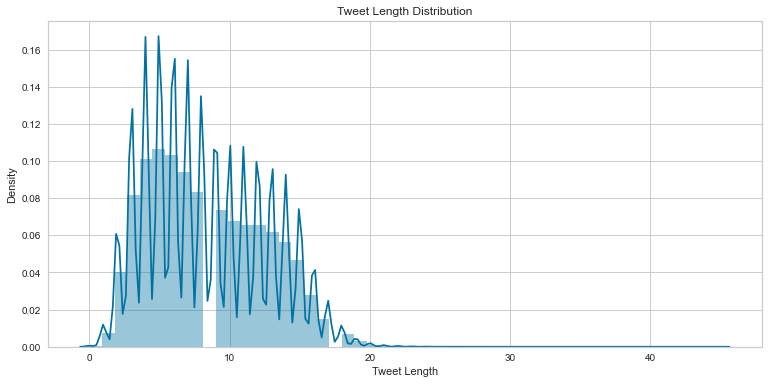

In [18]:
train_df['Tweet Length'] = train_df['Words'].str.len()

plt.figure(figsize=(12.8,6))
sns.distplot(train_df['Tweet Length']).set_title('Tweet Length Distribution')

/Users/ras/miniconda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Tweet Length Distribution (trimmed @ 95th percentile)')

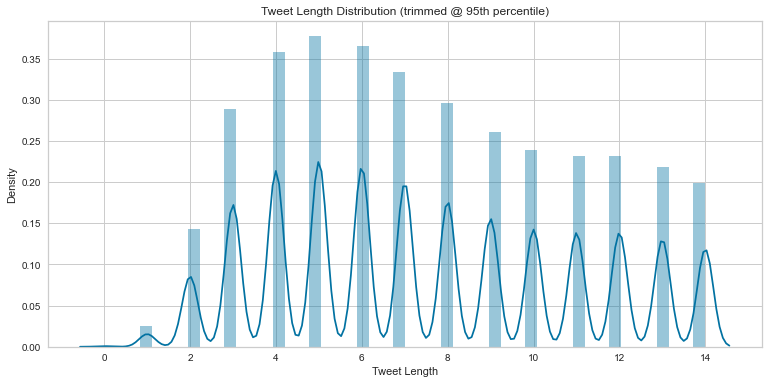

In [19]:
quantile_95 = train_df['Tweet Length'].quantile(0.95)
df_95 = train_df[train_df['Tweet Length'] < quantile_95]

plt.figure(figsize=(12.8,6))
sns.distplot(df_95['Tweet Length']).set_title('Tweet Length Distribution (trimmed @ 95th percentile)')

<AxesSubplot:xlabel='Label', ylabel='Tweet Length'>

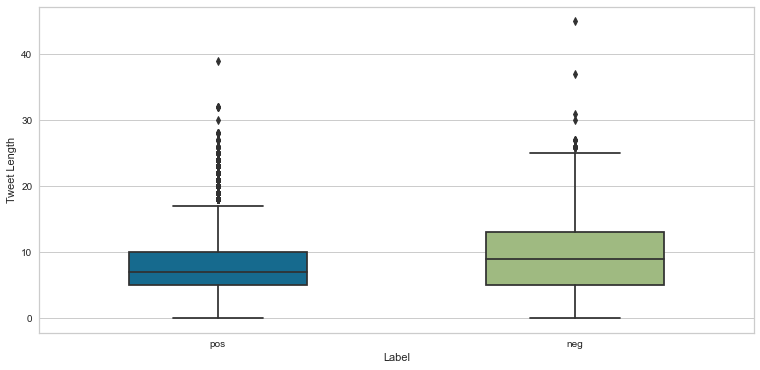

In [20]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=train_df, x='Label', y='Tweet Length', width=.5)

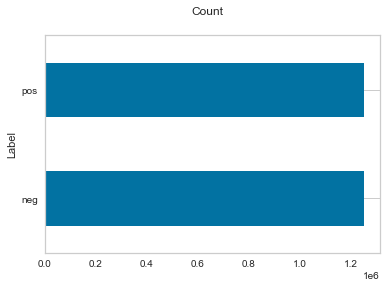

In [21]:
fig, ax = plt.subplots()
fig.suptitle("Count", fontsize=12)
train_df["Label"].reset_index().groupby("Label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [22]:
train_df['Tweet Length'].describe()

count    2.500000e+06
mean     8.360368e+00
std      4.146807e+00
min      0.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.200000e+01
max      4.500000e+01
Name: Tweet Length, dtype: float64

## TFIDF

In [23]:
train_idx, val_idx = train_test_split(list(range(len(train_df))), test_size=0.2)

train_ds = train_df.iloc[train_idx].reset_index()
val_ds = train_df.iloc[val_idx].reset_index()

train_words = train_ds['Words']
train_lab = train_ds['Label']

val_words = val_ds['Words']
val_lab = val_ds['Label']

test_words = test_df['Words']

In [24]:
split = [tuple([list(range(0, len(train_lab))), list(range(len(train_lab), len(train_lab) + len(val_lab)))])]

In [25]:
le = preprocessing.LabelEncoder()
le.fit(train_lab)
print("Labels: {}".format(list(le.classes_)))

Y_train_test = le.transform(pd.concat([train_lab, val_lab], ignore_index=True))
Y_train = le.transform(train_lab)

Labels: ['neg', 'pos']


In [26]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    ngram_range=(1,2),
    max_df=0.5,
    min_df=100)

In [27]:
# Fitting the tfidf model
tfidf.fit(train_words)
feature_names = tfidf.get_feature_names_out()

In [28]:
print("Number of features: {}".format(len(tfidf.idf_)))

Number of features: 20854


In [29]:
X_train_test = tfidf.transform(pd.concat([train_words, val_words], ignore_index=True))
X_train = tfidf.transform(train_words)

print("X_train shape is {}".format(X_train.shape))

print("Y_train dim is {}".format(Y_train.shape[0]))

X_train shape is (2000000, 20854)
Y_train dim is 2000000


In [30]:
# Classification
clf_svc = LinearSVC(penalty='l1', dual=False, class_weight='balanced', fit_intercept=True,
                random_state=seed, tol=1e-5)

In [31]:
# Training curve
train = True
if train:
    clf_svc.fit(X_train, Y_train)
    dump(model_path)
    #learning_curve(clf_svc, X_train_test, Y_train_test, scoring='accuracy_full', cv=split) 

In [32]:
clf_svc = load(model_path)

In [33]:
Y_test = le.transform(val_lab)
X_test = tfidf.transform(val_words)

# Plotting scores
y_pred = clf_svc.predict(X_test)

f1 = f1_score(Y_test, y_pred, average="macro")

print("Test f1 score : %s "% f1)

f1_w = f1_score(Y_test, y_pred, average="weighted")

print("Test f1 weighted score : %s "% f1_w)

acc = accuracy_score(Y_test, y_pred)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.8114601104649122 
Test f1 weighted score : 0.811456420120863 
Test accuracy score : 0.811684 


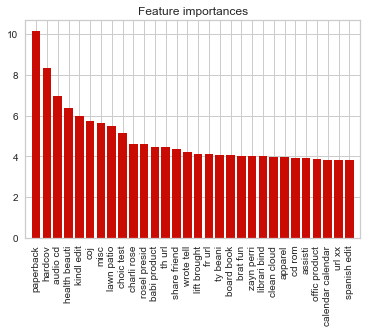

In [34]:
N=30

feature_imp = clf_svc.coef_[0]

indices = np.flip(np.argsort(np.absolute(feature_imp)))

plt.figure()
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("Feature importances")
plt.bar(range(N), np.absolute(feature_imp[indices[:N]]),
        color="r", align="center")
plt.xticks(range(N), feature_names[indices[:N]], rotation=90)
plt.xlim([-1, N])
plt.show()



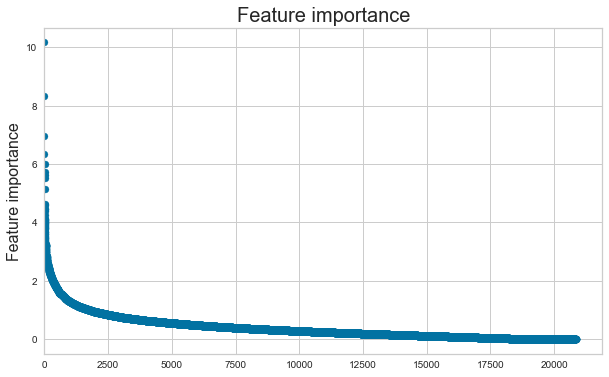

In [35]:
feature_imp = clf_svc.coef_[0]
  
features = np.flip(np.sort(np.absolute(feature_imp)))
plt.figure(figsize = (10,6))
plt.scatter(x = range(features.shape[0]), y = features)
plt.xlim(left = 0)
plt.ylabel("Feature importance", size = 16)
plt.title("Feature importance", size = 20)
plt.show()

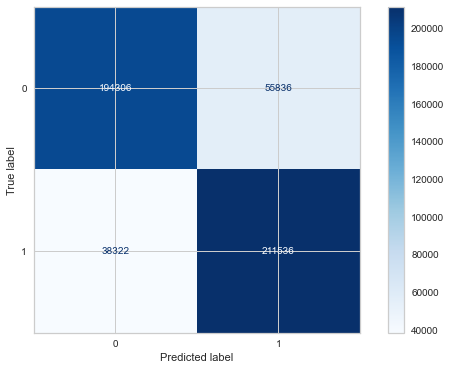

In [36]:
# Plotting confusion matrix
cm = confusion_matrix(Y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [37]:
X_test = tfidf.transform(test_words)
results = clf_svc.predict(X_test)
predicted = [1 if val > 0.5 else -1 for val in results]
df = pd.DataFrame(predicted, columns=["Prediction"])
df.index.name = "Id"
df.index += 1
df.to_csv(save_preds)